In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/healthcare-dataset-stroke-data.csv"

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:\n", df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

First 5 Rows:
       id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1   

In [ ]:
# Drop ID column (not useful for prediction)
df.drop(columns=['id'], inplace=True)

# Handle missing values (BMI)
print(f"Missing Values:\n{df.isnull().sum()}")
imputer = KNNImputer(n_neighbors=5)  # KNN Imputation for BMI
df['bmi'] = imputer.fit_transform(df[['bmi']])


Missing Values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
# Encode categorical variables
label_encoders = {}
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Feature scaling
scaler = MinMaxScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

# Define features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Check class distribution
print("\nClass Distribution Before Resampling:\n", y.value_counts())

# Handle imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Balance the minority class to 50% of the majority class
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass Distribution After SMOTE:\n", y_resampled.value_counts())


Class Distribution Before Resampling:
 stroke
0    4861
1     249
Name: count, dtype: int64

Class Distribution After SMOTE:
 stroke
0    4861
1    2430
Name: count, dtype: int64


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train baseline XGBoost model with class weight
stroke_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]  # Calculate imbalance ratio
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=stroke_ratio)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Hyperparameter tuning (Grid Search)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=stroke_ratio),
                           param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest Parameters from Grid Search:", grid_search.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
# Train final model with best parameters
best_params = grid_search.best_params_
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=stroke_ratio)
final_model.fit(X_train, y_train)

# Final predictions and evaluation
y_final_pred = final_model.predict(X_test)
y_final_prob = final_model.predict_proba(X_test)[:, 1]

print("\nFinal Model Classification Report:\n", classification_report(y_test, y_final_pred))
print("Final ROC-AUC Score:", roc_auc_score(y_test, y_final_prob))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       973
           1       0.85      0.91      0.88       486

    accuracy                           0.92      1459
   macro avg       0.90      0.91      0.91      1459
weighted avg       0.92      0.92      0.92      1459

Final ROC-AUC Score: 0.9728682662335739


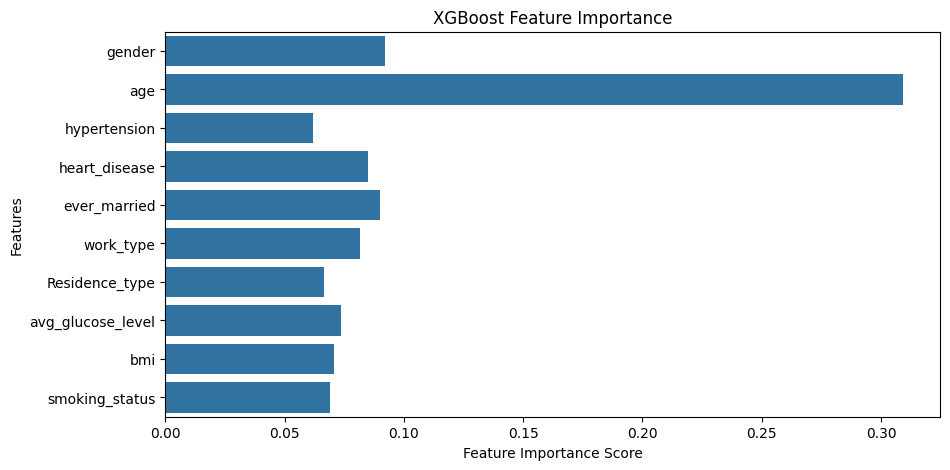

In [ ]:
# Feature Importance Visualization
feature_importance = final_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

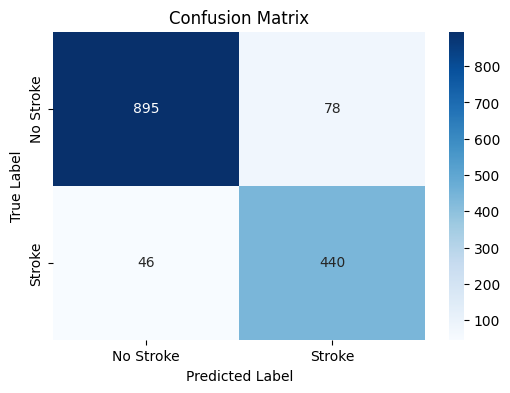

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_final_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()